In [82]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import matplotlib.pyplot as plt
import sys, random
from cosmojo.universe import Cosmo
from cosmojo.utils import nl_cmb, bl
from scipy.integrate import simps
from astropy.io import fits
from astropy.visualization import hist

import healpy as hp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
def AddPtSrcs(mymap_, nsrc=100, amp=10., sigma=0., f_unique=1., return_ipix=False):
    assert (f_unique >= 0.) or (f_unique <= 1.)
    mymap = mymap_.copy()
    nsrc_unique = int(f_unique * nsrc)
    nsrc_duplic = nsrc - nsrc_unique 
    ipix_unique = np.random.choice(mymap.size, nsrc_unique, replace=False)
    ipix_duplic = np.random.choice(ipix_unique, nsrc_duplic, replace=True)
    ipix = np.concatenate([ipix_unique, ipix_duplic])
    if sigma == 0.:
        mymap[ipix] += amp
    else:
        amps = np.random.normal(loc=amp, scale=sigma, size=ipix.size)
        mymap[ipix] += amps
        
    if return_ipix: 
        return mymap, ipix  
    else:
        return mymap
    
def GetClTot(pixmap, beam=0.,mask=None, lmax=None, pixwin=False):
    """
    Extract power spectrum from map and deconvolve for Masking, Pixel Window, Beam
    """
    nside = hp.npix2nside(pixmap.size)
    if mask is None:
        mask = np.ones_like(pixmap)
        fsky = 1.
    else:
        assert hp.isnpixok(mask.size)
        fsky = np.mean(mask**2)
    
    cl = hp.anafast(pixmap*mask, lmax=lmax)
    
    if lmax is None:
        lmax = cl.size - 1 
    
    if pixwin:
        cl /= hp.pixwin(nside)[:lmax+1]**2 # Pixel window funct
    cl /= hp.gauss_beam(np.deg2rad(beam/60.), lmax=lmax)**2 # Beam 
    cl /= fsky # Masking effect
    
    return cl
    
def filter_highpass_lowpass_1d(reclen, lmin, dl): # to smoothly filter out large scales 
    # central_freq = samp_freq/float(reclen)
    l = np.arange(reclen)#/2+1) * central_freq
    filt = np.ones(reclen)
    filt[l<lmin-dl/2] = 0.0

    window_for_transition_to_zero = (lmin-dl/2 <= l) * (l <= lmin+dl/2)
    ind=np.where(window_for_transition_to_zero==True)[0]
    reclen_transition_window = len(filt[window_for_transition_to_zero])
    filt[window_for_transition_to_zero] = (1. - np.cos( np.pi* np.arange(reclen_transition_window) /(reclen_transition_window-1))) /2.0

    return filt
        
def GetFl(pixmap, fwhm, mask=None, lmax=None, lmin=300, dl=100):
    """
    Returns the filter function Eq. 4 of Soergel
    """
    if lmax is None:
        lmax = 3.*hp.npix2nside(pixmap.size) - 1.
    fwhm_rad = np.deg2rad(fwhm/60.)
    sigma = fwhm_rad/np.sqrt(8.*np.log(2))
    Bl = hp.gauss_beam(fwhm_rad, lmax=lmax)
    Bl_tilde = 2.*np.pi*sigma**2*Bl
    Cl_tot = GetClTot(pixmap, beam=fwhm, mask=mask, lmax=lmax)
    ell = np.arange(lmax+1)
    return filter_highpass_lowpass_1d(ell.size, lmin=lmin, dl=dl)  * Bl_tilde / (Cl_tot * np.sum((2.*ell+1)*Bl_tilde**2/(4.*np.pi*Cl_tot)))

def FilterMap(pixmap, fwhm, mask=None, lmax=None):
    if mask is None:
        mask = np.ones_like(pixmap)
    else:
        assert hp.isnpixok(mask.size)
    Fl = GetFl(pixmap, fwhm, mask=mask, lmax=lmax)
    alm = hp.map2alm(pixmap*mask, lmax=lmax)
    return hp.alm2map(hp.almxfl(alm, Fl), hp.npix2nside(pixmap.size), lmax=lmax), Fl

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def Kcmb2MJysr(nu, cmb, T_cmb=2.725):
    if nu == 353:
        return 287.450 * cmb
    elif nu == 217:
        return  483.690 * cmb

In [3]:
# Generate theoretical CMB power spectrum and noise

noise_muK_arcmin = 30.
beam = 5.
nside = 2048

cltt = Cosmo(lmax=8000).cmb_spectra(8000, dl=False)[:,0]
nltt = nl_cmb(noise_muK_arcmin, 0., lmax=10000) # 20 \muK, no beam because I smooth later


In [71]:
# Create maps
tt_map  = hp.synfast(cltt, nside, ) # CMB
ntt_map = hp.synfast(nltt, nside, ) # Noise
tt_src_map, ipix = AddPtSrcs(tt_map, nsrc=5e4, amp=10., sigma=0., f_unique=.6, return_ipix=True) # CMB + srcs
tt_src_map_smooth = hp.smoothing(tt_src_map, fwhm=np.radians(beam/60.)) # (CMB + srcs) * beam

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Sigma is 2.123305 arcmin (0.000618 rad) 
-> fwhm is 5.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [76]:
tot_map = tt_src_map_smooth + ntt_map

In [79]:
tot_map_filt, fl = FilterMap(tot_map, beam, lmax=6000)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


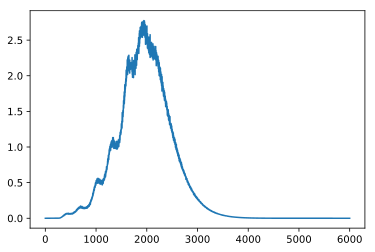

In [80]:
plt.plot(fl)

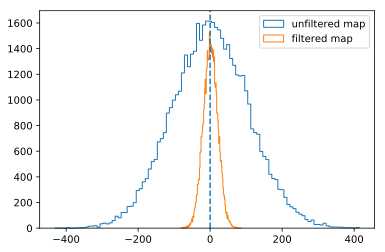

In [89]:
hist(tot_map[ipix], 'knuth', label='unfiltered map', histtype='step')
hist(tot_map_filt[ipix], 'knuth', label='filtered map', histtype='step', )
plt.axvline(ls='--')
plt.legend()

In [136]:
# Take the vector of fluxes and sum just the pixels
fluxes = tot_map_filt[ipix]
fluxes_unique = tot_map_filt[np.unique(ipix)]
rnd_pix = np.random.randint(0, hp.nside2npix(nside), fluxes.size)
fluxes_rnd = tot_map_filt[rnd_pix] 

In [137]:
print '~~~~~~~~SIMPLE MEAN~~~~~~~~~~~~~~~'
print 'Mean of fluxes is........: %.3f mJy' %np.mean(fluxes)
print 'STD  of fluxes is........: %.3f mJy' %np.std(fluxes)
print 'STD/sqrt(n)  of fluxes is: %.3f mJy' %(np.std(fluxes)/fluxes.size**.5)

~~~~~~~~SIMPLE MEAN~~~~~~~~~~~~~~~
Mean of fluxes is........: 0.962 mJy
STD  of fluxes is........: 20.421 mJy
STD/sqrt(n)  of fluxes is: 0.091 mJy


In [138]:
print '~~~~~~~~SIMPLE MEAN~~~~~~~~~~~~~~~'
print 'Mean of **RND** fluxes is........: %.3f mJy' %np.mean(fluxes_rnd)
print 'STD  of **RND** fluxes is........: %.3f mJy' %np.std(fluxes_rnd)
print 'STD/sqrt(n)  of **RND** fluxes is: %.3f mJy' %(np.std(fluxes_rnd)/fluxes_rnd.size**.5)

~~~~~~~~SIMPLE MEAN~~~~~~~~~~~~~~~
Mean of **RND** fluxes is........: -0.056 mJy
STD  of **RND** fluxes is........: 20.467 mJy
STD/sqrt(n)  of **RND** fluxes is: 0.092 mJy


In [139]:
print '~~~~~~~~MEAN ON UNIQUE PIX~~~~~~~~~~~~~~~'
print 'Mean of fluxes is........: %.3f mJy' %np.mean(fluxes_unique)
print 'STD  of fluxes is........: %.3f mJy' %np.std(fluxes_unique)
print 'STD/sqrt(n)  of fluxes is: %.3f mJy' %(np.std(fluxes_unique)/fluxes_unique.size**.5)

~~~~~~~~MEAN ON UNIQUE PIX~~~~~~~~~~~~~~~
Mean of fluxes is........: 1.029 mJy
STD  of fluxes is........: 20.408 mJy
STD/sqrt(n)  of fluxes is: 0.118 mJy
